# FLEKS Python Visualization Toolkit: IDL Data

flekspy is a Python package for processing FLEKS data. This notebook focuses on handling data in the IDL format.

## FLEKS data format

* Field: *.out format or AMREX built-in format, whose directory name is assumed to end with "_amrex"
* PIC particle: AMREX built-in format 
* Test particle: binary data format

## Importing the package

In [1]:
import flekspy

## Downloading demo data

If you don't have FLEKS data to start with, you can download demo field data with the following:

In [2]:
from flekspy.util import download_testfile

url = "https://raw.githubusercontent.com/henry2004y/batsrus_data/master/batsrus_data.tar.gz"
download_testfile(url, "data")

## Loading data

`flekspy.load` is the interface to read files of all formats. It returns a different object for different formats. IDL format data are processed into XArray data structures:

In [3]:
file = "data/1d__raw_2_t25.60000_n00000258.out"
ds = flekspy.load(file)
ds

<xarray.Dataset> Size: 31kB
Dimensions:  (x: 256)
Coordinates:
  * x        (x) float64 2kB -127.5 -126.5 -125.5 -124.5 ... 125.5 126.5 127.5
Data variables: (12/14)
    Rho      (x) float64 2kB 1.0 1.0 1.0 1.0 1.0 ... 0.125 0.125 0.125 0.125
    Mx       (x) float64 2kB 5.791e-14 1.309e-13 ... 1.92e-11 9.193e-12
    My       (x) float64 2kB 1.718e-13 5.386e-13 1.697e-12 ... 2.808e-11 1.2e-11
    Mz       (x) float64 2kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    Bx       (x) float64 2kB 0.2236 0.2236 0.2236 0.2236 ... 1.118 1.118 1.118
    By       (x) float64 2kB 1.23 1.23 1.23 1.23 ... -0.559 -0.559 -0.559 -0.559
    ...       ...
    E        (x) float64 2kB 1.781 1.781 1.781 1.781 ... 0.8813 0.8813 0.8813
    p        (x) float64 2kB 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.1 0.1 0.1 0.1 0.1 0.1
    b1x      (x) float64 2kB 0.2236 0.2236 0.2236 0.2236 ... 1.118 1.118 1.118
    b1y      (x) float64 2kB 1.23 1.23 1.23 1.23 ... -0.559 -0.559 -0.559 -0.559
    b1z      (x) float64 2kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    absdivB  (x) float64 2kB 6.466e-13 1.994e-12 ... 2.394e-12 8.149e-12
Attributes: (12/19)
    filename:    /app/docs/data/1d__raw_2_t25.60000_n00000258.out
    isOuts:      False
    npict:       1
    nInstance:   1
    fileformat:  ascii
    unit:        normalized
    ...          ...
    npoints:     256
    para:        [3. 2. 0. 0.]
    dims:        ['x']
    variables:   ['x' 'Rho' 'Mx' 'My' 'Mz' 'Bx' 'By' 'Bz' 'Hyp' 'E' 'p' 'b1x'...
    strtime:     0000h00m25.600s
    param_name:  ['r' 'g' 'cuty' 'cutz']

The coordinates can be accessed via

In [4]:
ds.coords

Coordinates:
  * x        (x) float64 2kB -127.5 -126.5 -125.5 -124.5 ... 125.5 126.5 127.5

The variables can be accessed via

In [5]:
ds.var

<bound method DatasetAggregations.var of <xarray.Dataset> Size: 31kB
Dimensions:  (x: 256)
Coordinates:
  * x        (x) float64 2kB -127.5 -126.5 -125.5 -124.5 ... 125.5 126.5 127.5
Data variables: (12/14)
    Rho      (x) float64 2kB 1.0 1.0 1.0 1.0 1.0 ... 0.125 0.125 0.125 0.125
    Mx       (x) float64 2kB 5.791e-14 1.309e-13 ... 1.92e-11 9.193e-12
    My       (x) float64 2kB 1.718e-13 5.386e-13 1.697e-12 ... 2.808e-11 1.2e-11
    Mz       (x) float64 2kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    Bx       (x) float64 2kB 0.2236 0.2236 0.2236 0.2236 ... 1.118 1.118 1.118
    By       (x) float64 2kB 1.23 1.23 1.23 1.23 ... -0.559 -0.559 -0.559 -0.559
    ...       ...
    E        (x) float64 2kB 1.781 1.781 1.781 1.781 ... 0.8813 0.8813 0.8813
    p        (x) float64 2kB 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.1 0.1 0.1 0.1 0.1 0.1
    b1x      (x) float64 2kB 0.2236 0.2236 0.2236 0.2236 ... 1.118 1.118 1.118
    b1y      (x) float64 2kB 1.23 1.23 1.23 1.23 ... -0.559 -0.559

and individual variables can be accessed through keys or properties:

In [6]:
ds["p"]
ds.p

<xarray.DataArray 'p' (x: 256)> Size: 2kB
array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999999, 0.99999999,
       0.99999999, 0.99999998, 0.99999997, 0.99999996, 0.99999995,
       0.99999994, 0.99999992, 0.99999989, 0.99999986, 0.99999982,
       0.99999977, 0.99999971, 0.99999964, 0.99999955, 0.99999944,
       0.99999931, 0.99999915, 0.99999896, 0.99999873, 0.99999846,
       0.99999813, 0.99999775, 0.99999729, 0.99999676, 0.99999612,
       0.99999538, 0.9999945 , 0.99999348, 0.99999229, 0.99999089,
       0.99998927, 0.99998739, 0.9999852 , 0.99998266, 0.99997971,
       0.99997631, 0.99997238, 0.99996784, 0.99996262, 0.99995661,
       0.99994971, 0.9999418 , 0.99993277, 0.99992245, 0.99991061,
       0.99989688, 0.99988076, 0.99986169, 0.99983926, 0.99981363,
       0.99978593, 0.99975843, 0.99973409, 0.99971417, 0.99969689,
       0.99967628, 0.9996342 , 0.99948851, 0.99875656, 0.99520955,
       0.98644347, 0.97296833, 0.95605524, 0.93689582, 0.91642986,
       0.89531082, 0.87393959, 0.85255455, 0.83129714, 0.81025231,
       0.78947393, 0.76899764, 0.74884761, 0.72904066, 0.70958859,
       0.69049963, 0.67177964, 0.6534332 , 0.63546454, 0.6178779 ,
       0.60067737, 0.58386638, 0.56744599, 0.55141095, 0.5357435 ,
...
       0.51903728, 0.51937986, 0.51946056, 0.51934921, 0.51897835,
       0.51808309, 0.51597448, 0.50838603, 0.47777544, 0.37490815,
       0.18275943, 0.09437588, 0.08721111, 0.08711243, 0.08735865,
       0.08766624, 0.0878924 , 0.08798467, 0.08799348, 0.08798877,
       0.08797256, 0.08793813, 0.08786602, 0.08773117, 0.08758445,
       0.08751411, 0.08750803, 0.08751301, 0.08753202, 0.08757715,
       0.08762349, 0.0876353 , 0.08763337, 0.0876259 , 0.08760677,
       0.08758085, 0.08757283, 0.08757511, 0.0875862 , 0.0876146 ,
       0.08767738, 0.08777552, 0.08786197, 0.0878934 , 0.08789452,
       0.0878902 , 0.08787545, 0.08783555, 0.08774973, 0.08757955,
       0.08727059, 0.08688917, 0.08660118, 0.08652576, 0.08652704,
       0.08655168, 0.08662743, 0.08679863, 0.08714811, 0.08775512,
       0.08855411, 0.08946919, 0.09044863, 0.0914582 , 0.09247696,
       0.09349335, 0.09449866, 0.0954875 , 0.09645212, 0.0973789 ,
       0.09825058, 0.0990272 , 0.09964004, 0.09996659, 0.10003448,
       0.10004239, 0.10004135, 0.10003742, 0.10003136, 0.10002179,
       0.10001115, 0.10000324, 0.10000038, 0.1       , 0.09999996,
       0.09999996, 0.09999997, 0.09999999, 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       ])
Coordinates:
  * x        (x) float64 2kB -127.5 -126.5 -125.5 -124.5 ... 125.5 126.5 127.5

### Unstructured data

Unstructured data is handled with [Xugrid](https://deltares.github.io/xugrid/index.html), with support of regridding and partitioning.

In [7]:
file = "data/bx0_mhd_6_t00000100_n00000352.out"
dsu = flekspy.load(file)
dsu


<xarray.Dataset> Size: 12kB
Dimensions:        (mesh2d_nNodes: 116)
Coordinates:
  * mesh2d_nNodes  (mesh2d_nNodes) int64 928B 0 1 2 3 4 ... 111 112 113 114 115
Data variables:
    z              (mesh2d_nNodes) float64 928B -6.101 -6.092 ... 3.337 1.229
    Rho            (mesh2d_nNodes) float64 928B 6.193 6.882 7.506 ... 5.0 5.0
    Ux             (mesh2d_nNodes) float64 928B -141.3 -71.76 ... -400.0 -400.0
    Uy             (mesh2d_nNodes) float64 928B 2.051 3.735 ... 0.01255 0.005612
    Uz             (mesh2d_nNodes) float64 928B -2.972 0.0389 ... -0.01299
    Bx             (mesh2d_nNodes) float64 928B 0.0 4.441e-16 ... -5.551e-17 0.0
    By             (mesh2d_nNodes) float64 928B 46.6 82.78 ... -1.806 -1.606
    Bz             (mesh2d_nNodes) float64 928B -16.46 -51.48 ... -6.71 -7.88
    P              (mesh2d_nNodes) float64 928B 0.1882 0.1859 ... 0.006932
    jx             (mesh2d_nNodes) float64 928B 6.185e-05 ... 1.214e-06
    jy             (mesh2d_nNodes) float64 928B -0.0003398 ... -4.26e-07
    jz             (mesh2d_nNodes) float64 928B -0.0006739 ... 4.019e-06
Attributes: (12/19)
    filename:    /app/docs/data/bx0_mhd_6_t00000100_n00000352.out
    isOuts:      False
    npict:       1
    nInstance:   1
    fileformat:  ascii
    unit:        2000-06-21T10:46:00;
    ...          ...
    npoints:     116
    para:        [6.37800e+06 2.50000e+00 1.66667e+00]
    dims:        ['x', 'y']
    variables:   ['x' 'y' 'z' 'Rho' 'Ux' 'Uy' 'Uz' 'Bx' 'By' 'Bz' 'P' 'jx' 'j...
    strtime:     0000h01m00.000s
    param_name:  ['xSI' 'r' 'g']

### Interpolating data

Variable interpolation is supported via [XArray](https://docs.xarray.dev/en/stable/user-guide/interpolation.html). For 1D data, simply provide the coordinate:

In [8]:
ds["Rho"].interp(x=100)

<xarray.DataArray 'Rho' ()> Size: 8B
array(0.12245273)
Coordinates:
    x        int64 8B 100

For multidimensional interpolation, it can be easily extended as

In [9]:
file = "data/z=0_fluid_region0_0_t00001640_n00010142.out"
ds = flekspy.load(file)
ds["rhoS0"].interp(x=-28000.0, y =0.0)

<xarray.DataArray 'rhoS0' ()> Size: 8B
array(0.12202676)
Coordinates:
    x        float64 8B -2.8e+04
    y        float64 8B 0.0

If you want to interpolate for all variables at a single location,

In [10]:
ds.interp(x=-28000.0, y =0.0)

<xarray.Dataset> Size: 240B
Dimensions:  ()
Coordinates:
    x        float64 8B -2.8e+04
    y        float64 8B 0.0
Data variables: (12/28)
    rhoS0    float64 8B 0.122
    rhoS1    float64 8B 12.28
    Bx       float64 8B 0.2617
    By       float64 8B 0.1596
    Bz       float64 8B 20.24
    Ex       float64 8B 411.3
    ...       ...
    pXXS1    float64 8B 0.4068
    pYYS1    float64 8B 0.3315
    pZZS1    float64 8B 0.08105
    pXYS1    float64 8B -0.0111
    pXZS1    float64 8B -0.004809
    pYZS1    float64 8B 0.008121
Attributes: (12/22)
    filename:    /app/docs/data/z=0_fluid_region0_0_t00001640_n00010142.out
    isOuts:      False
    npict:       1
    nInstance:   1
    fileformat:  binary
    end_char:    <
    ...          ...
    npoints:     1202
    para:        [ 9.99999978e-03 -2.50000000e-01  1.00000000e+00  2.50000000...
    dims:        ['x', 'y']
    variables:   ['x' 'y' 'rhoS0' 'rhoS1' 'Bx' 'By' 'Bz' 'Ex' 'Ey' 'Ez' 'uxS0...
    strtime:     0000h16m40.021s
    param_name:  ['mS0' 'qS0' 'mS1' 'qS1' 'cLight' 'rPlanet' 'cutz']

## Visualizing fields

Thanks to XArray's Matplotlib wrapper, all Matplotlib's plotting functionalities are directly supported.

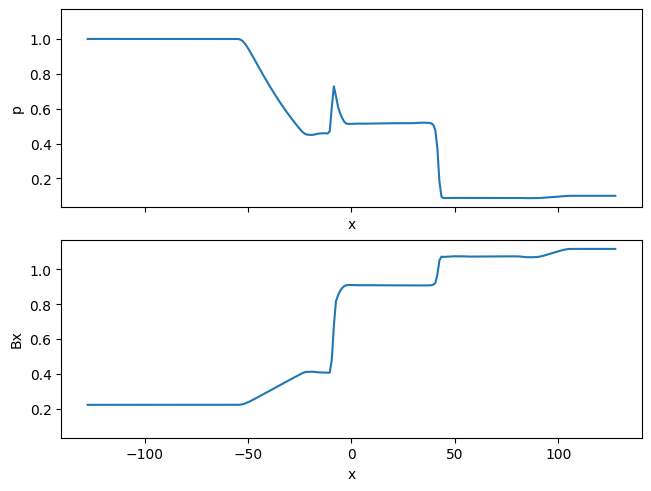

In [11]:
import matplotlib.pyplot as plt

file = "data/1d__raw_2_t25.60000_n00000258.out"
ds = flekspy.load(file)

fig, axs = plt.subplots(2, 1, constrained_layout=True, sharex=True, sharey=True)
ds.p.plot(ax=axs[0])
ds.Bx.plot(ax=axs[1])
plt.show()

By default, XArray's 2D plotting functions map the first dimension to the vertical y-axis and the second dimension to the horizontal x-axis. To overwrite this default behavior, we can explicitly set the `x` and `y` arguments:

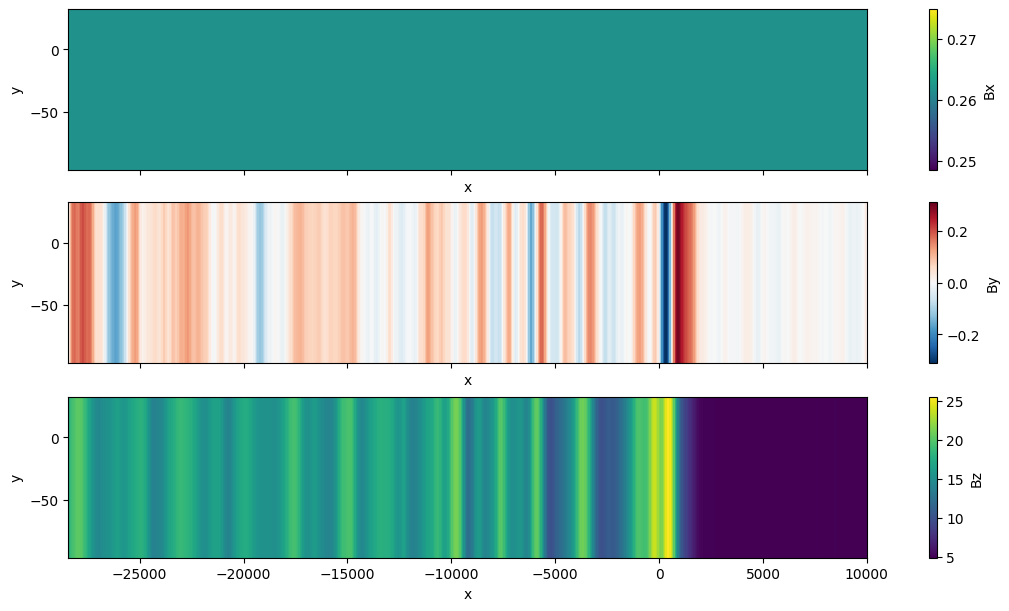

In [12]:
file = "data/z=0_fluid_region0_0_t00001640_n00010142.out"
ds = flekspy.load(file)
fig, axs = plt.subplots(
    3, 1, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True
)
ds.Bx.plot.pcolormesh(ax=axs[0], x="x", y="y")
ds.By.plot.pcolormesh(ax=axs[1], x="x", y="y")
ds.Bz.plot.pcolormesh(ax=axs[2], x="x", y="y")
plt.show()

Unstructured IDL format output plotting is supported directly by [Xugrid](https://deltares.github.io/xugrid/examples/plotting.html). Note that here we need an additional level `ugrid` compared to direct plotting via `xarray`.

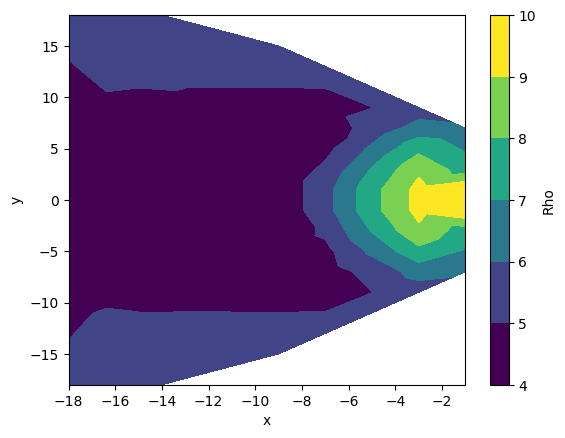

In [13]:
dsu.Rho.ugrid.plot.contourf()
plt.show()

## Derived Variables

### Pressure Anisotropy

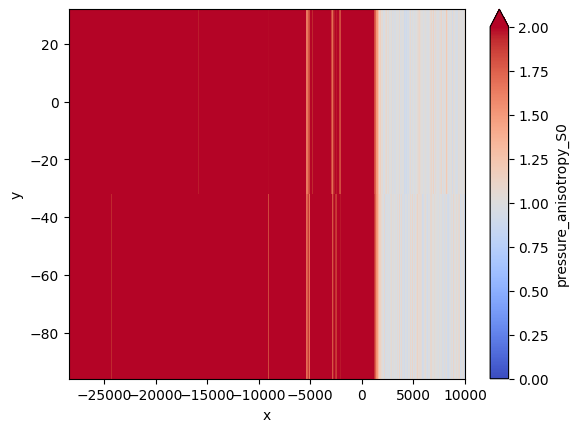

In [14]:
import matplotlib.pyplot as plt
file = 'data/z=0_fluid_region0_0_t00001640_n00010142.out'
ds = flekspy.load(file)
anisotropy = ds.idl.get_pressure_anisotropy(species=0)
anisotropy.plot.pcolormesh(x='x', y='y', cmap='coolwarm', vmin=0, vmax=2)
plt.show()

### Current density

Current density can be calculated in two ways: from the curl of the magnetic field or from the definition J = nqv. Both methods are available in the IDL accessor.

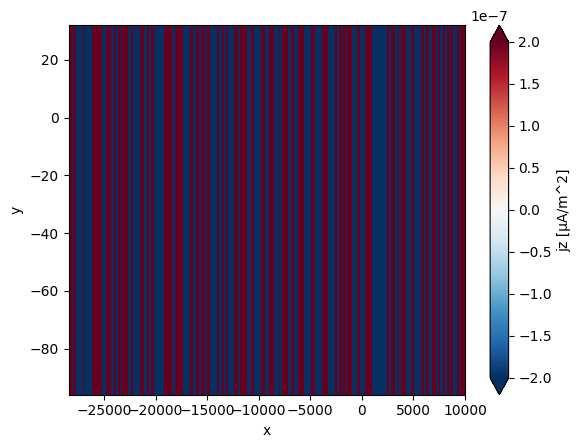

In [15]:
current_curl = ds.idl.get_current_density()
current_curl['jz'].plot.pcolormesh(x='x', y='y', cmap='RdBu_r', vmax=2e-7)
plt.show()

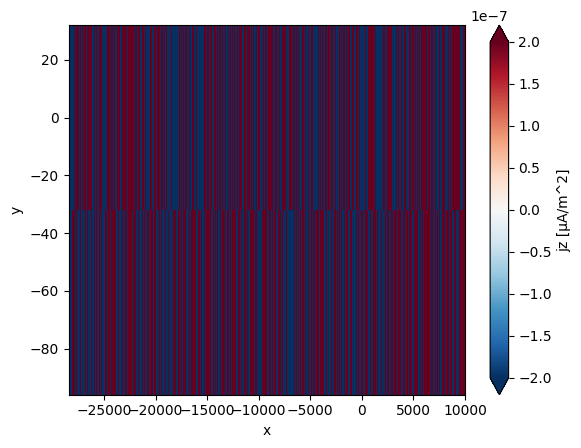

In [16]:
current_def = ds.idl.get_current_density_from_definition(species=[0, 1])
current_def['jz'].plot.pcolormesh(x='x', y='y', cmap='RdBu_r', vmax=2e-7)
plt.show()